This notebook is designed to fuse data from ddm-metrics, which provides link information, and rucio-events, which provides file-level data.

From rucio-events, we compute the time-in-queue and time-in-transfer for each file, and record the filesize and activity type for each data point. Gathering all data like this adds up quickly, so some sort of sampling will likely be required.

Once all the data is acquired, the next step is to combine all the data into a model, with filesize,activity, throughput, and packetloss as inputs, and total time to complete as the output.

Currently looking at decision trees and multiple regression to create model. Since activity is categorical, starting with decision trees.

In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
matplotlib.rc('font', **{'size': 15})


src = 'AGLT2'
src = 'CERN-PROD'
dst = 'BNL-ATLAS'


#Create instance of ElasticSearch using the Atlas host server
es1 = Elasticsearch(hosts=[{'host':'atlas-kibana-2.mwt2.org', 'port':9200}],timeout=60)
 

In [2]:
query1 = '''{
    
  "size": 10000,
  "sort": [
    {
      "@timestamp": {
        "order": "random",
      }
    }
  ],
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "payload.src-rse:CERN* AND payload.dst-rse:BNL* AND event_type:transfer-done",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "@timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "fielddata_fields": [
    "@timestamp","duration"
  ]
}'''

Let's initialize convenient durations in milliseconds for use in fetching data ranges.

In [3]:
import ast
import time
currentMilliTime = int(round(time.time()*1000))
milliWeek = 7*24*60*60*1000
milliTwoWeek = 2*7*24*60*60*1000
milliSixHour = 12*60*60*1000
milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
milliHalfDay = 12*60*60*1000

milliHour = 60*60*1000

In [4]:
#Get files day interval (stagger a little from current time to get more interesting data)
start = currentMilliTime - milliDay - milliHalfDay
end = currentMilliTime - milliHalfDay

#Get important variables from response
fileSize = []
activity = []
startedAt = []
submittedAt = []
transferredAt = []
duration = []
fileTimestamp = []

startPart = start
endPart = start

#Step through day, getting all data in range
for i in range(24):
    endPart += milliHour
    response = es1.search(index="rucio-events*", body=ast.literal_eval(query1%(startPart,endPart)), request_timeout=600)
    startPart = endPart + 1
    for r in response['hits']['hits']:
        fileTimestamp.append(r['fields']['@timestamp'])
        fileSize.append(r['_source']['payload']['file-size'])
        activity.append(r['_source']['payload']['activity'])
        startedAt.append(r['_source']['payload']['started_at'])
        submittedAt.append(r['_source']['payload']['submitted_at'])
        transferredAt.append(r['_source']['payload']['transferred_at'])

fileSize = np.array(fileSize)
activity = np.array(activity)
startedAt = np.array(startedAt)
submittedAt = np.array(submittedAt)
transferredAt = np.array(transferredAt)

In [5]:
import datetime
from datetime import datetime
import time

#Some useful functions for date conversion

def convertDateToEpoch(dates):
    
    epochDates = []
    zeroEpoch = datetime.datetime.utcfromtimestamp(0)
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")

        
def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0
        epochDates.append(epoch)
    return epochDates

def getSecondsDifference(epochDatesStart,epochDatesFinal):
    diff = []
    for i in range(len(epochDatesStart)):
        diff.append((epochDatesFinal[i] - epochDatesStart[i]).total_seconds())
    
    return diff



In [6]:
#Convert string timestamps to usable quantities

timeInQueue = getSecondsDifference(convertDateToEpoch(submittedAt),
                                   convertDateToEpoch(startedAt))
timeTotal = getSecondsDifference(convertDateToEpoch(submittedAt),
                                 convertDateToEpoch(transferredAt))
timeInTransfer = getSecondsDifference(convertDateToEpoch(startedAt),
                                      convertDateToEpoch(transferredAt))

timeInTransfer = np.array(timeInTransfer)
timeTotal = np.array(timeTotal)
timeInQueue = np.array(timeInQueue)


Now we want to get the data from the ddm-metrics index, so we need a new query structure, as well as a new host, with authentication.

In [7]:
#Get fields from another host

es2 = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)

query2 = '''{
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "src:%s AND dst:%s",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "10m",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": %i,
          "max": %i
        }
      },
      "aggs": {
        "1": {
          "avg": {
            "field": "%s"
          }
        }
      }
    }
  }
}'''

We query multiple times, getting number of queued files, packetloss, different throughputs, and corresponding timestamp values.

In [8]:


tic = time.time()

queuedQuery = ast.literal_eval(query2%(src,dst,start,end,start,end,'queued-total'))    
packetLossQuery = ast.literal_eval(query2%(src,dst,start,end,start,end,'packetloss'))  
dashThroughputQuery = ast.literal_eval(query2%(src,dst,start,end,start,end,'mbps-dashb-1h')) 
ftsThroughputQuery = ast.literal_eval(query2%(src,dst,start,end,start,end,'mbps-fts-1h')) 
faxThroughputQuery = ast.literal_eval(query2%(src,dst,start,end,start,end,'mbps-fax-1h')) 

queuedResponse = es2.search(index="atlas_ddm-metrics*", body=queuedQuery, request_timeout=600) 
packetLossResponse = es2.search(index="atlas_ddm-metrics*", body=packetLossQuery, request_timeout=600)
dashThroughputResponse = es2.search(index="atlas_ddm-metrics*", body=dashThroughputQuery, request_timeout=600)
ftsThroughputResponse = es2.search(index="atlas_ddm-metrics*", body=ftsThroughputQuery, request_timeout=600)
faxThroughputResponse = es2.search(index="atlas_ddm-metrics*", body=faxThroughputQuery, request_timeout=600)

queuedData = []
packetLoss = []
dashThroughput = []
faxThroughput = []
ftsThroughput = []
timestamp = []

for r in queuedResponse['aggregations']['2']['buckets']:
    queuedData.append(r['1']['value'])
    timestamp.append(r['key'])    
for r in packetLossResponse['aggregations']['2']['buckets']:
    packetLoss.append(r['1']['value'])
for r in dashThroughputResponse['aggregations']['2']['buckets']:
    dashThroughput.append(r['1']['value'])
for r in ftsThroughputResponse['aggregations']['2']['buckets']:
    ftsThroughput.append(r['1']['value'])
for r in faxThroughputResponse['aggregations']['2']['buckets']:
    faxThroughput.append(r['1']['value'])

#Replace None values with NaNs
queuedData = np.array(queuedData,dtype=np.float)
packetLoss = np.array(packetLoss,dtype=np.float)
timestamp = np.array(timestamp,dtype=np.float)
faxThroughput = np.array(faxThroughput,dtype=np.float)
ftsThroughput = np.array(ftsThroughput,dtype=np.float)
dashThroughput = np.array(dashThroughput,dtype=np.float)
timestamp = np.array(timestamp)


toc = time.time()

print('This aggregation and fetching took %f seconds'%(toc-tic))

This aggregation and fetching took 2.965928 seconds


Now time to display the results in a graph. This is data collected over the period of one day.

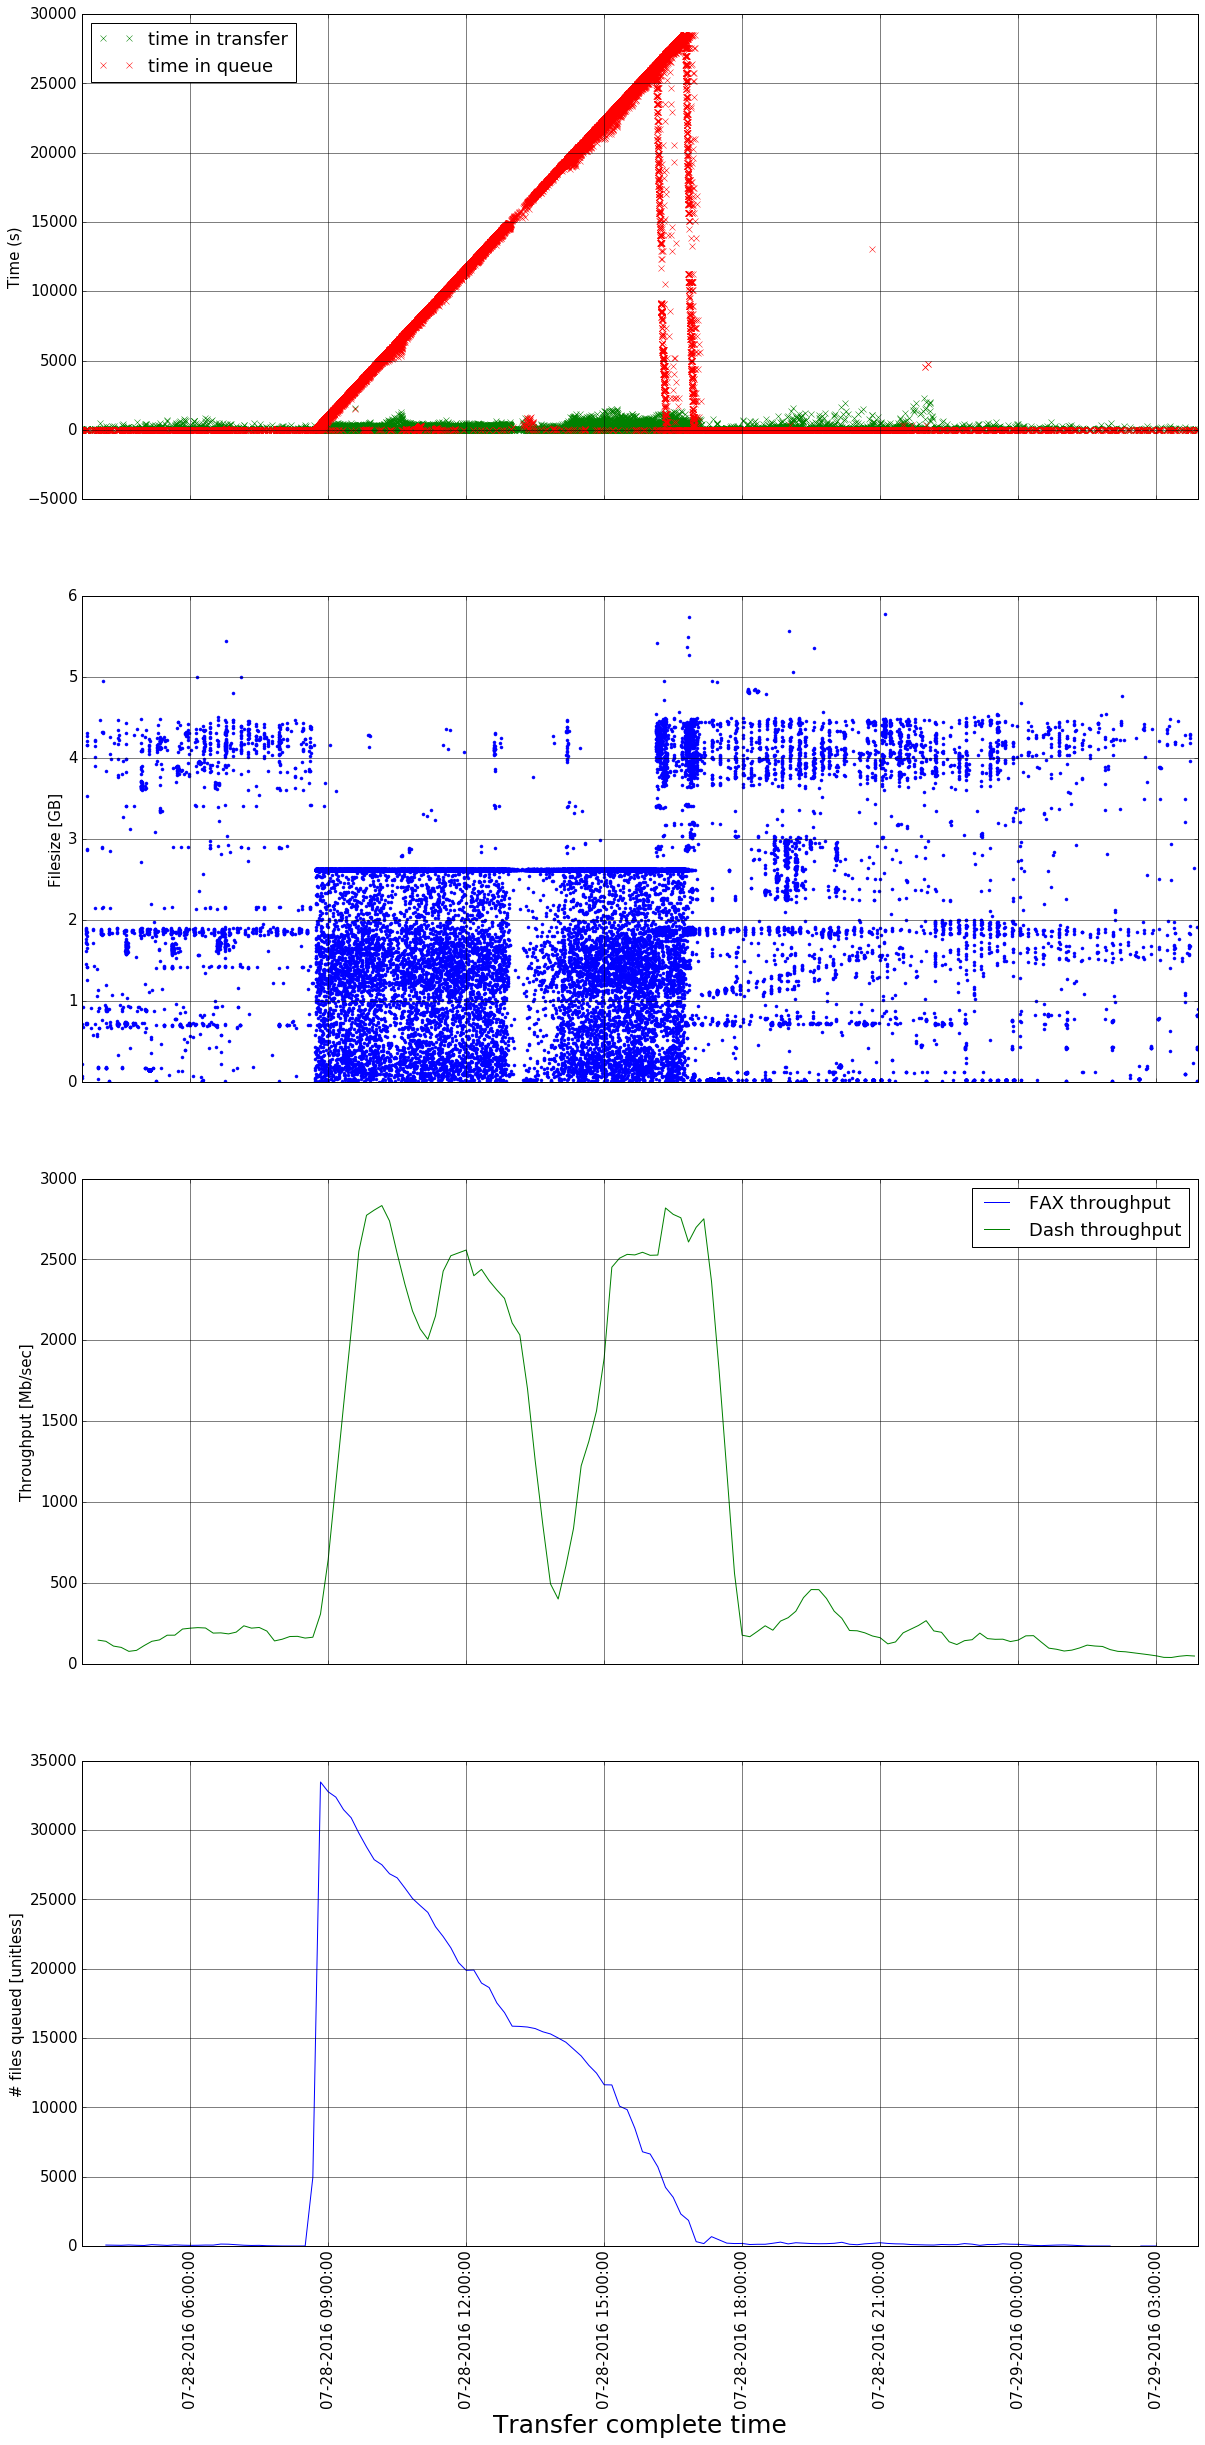

In [9]:
import matplotlib.dates as dt


dateTime = convertDateToEpoch(transferredAt)

dateTime2 = dt.epoch2num(timestamp/1000.)


plt.figure(figsize=(20,40))

ax1 = plt.subplot(411)
plt.plot(dateTime,timeInTransfer,'gx',label='time in transfer')
plt.plot(dateTime,timeInQueue,'rx',label='time in queue')

plt.ylabel('Time (s)')
plt.legend(loc='upper left')
plt.grid(which='major',linestyle='-')

#Tedious date/time formatting
xfmt = dt.DateFormatter('%m-%d-%Y %H:%M:%S')
ax1.xaxis.set_major_formatter(xfmt)
ax1.xaxis_date()
plt.setp(ax1.get_xticklabels(), visible=False)


ax2 = plt.subplot(412, sharex=ax1)

plt.plot(dateTime,fileSize/10**9,'b.')
plt.grid(which='major',linestyle='-')
plt.ylabel('Filesize [GB]')
plt.setp(ax2.get_xticklabels(), visible=False)

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(dateTime2,faxThroughput,label='FAX throughput')
plt.plot(dateTime2,dashThroughput,label='Dash throughput')
plt.legend()
plt.ylabel('Throughput [Mb/sec]')
plt.grid(which='major',linestyle='-')
plt.setp(ax3.get_xticklabels(), visible=False)


ax4 = plt.subplot(414, sharex=ax1)

plt.plot(dateTime2,queuedData)
plt.ylabel('# files queued [unitless]')
plt.xlabel('Transfer complete time',size=25)
plt.xticks(rotation= 90 )
plt.grid(which='major',linestyle='-')


In [10]:
import time
from datetime import datetime

def convertDateToMilli(dates):
    milliTime = []
    for i in range(len(dates)):
        #Use decimal version if the date string contains a decimal point
        if dates[i].find('.')==-1:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
        else:
            epoch = datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S.%f")
        milliTime.append(time.mktime(epoch.timetuple())*1e3 + epoch.microsecond/1e3)
    return milliTime

milliTime = convertDateToMilli(transferredAt)

In [11]:
timeInQueue

array([ 1.   ,  2.   ,  0.   , ...,  1.253,  1.034,  1.289])

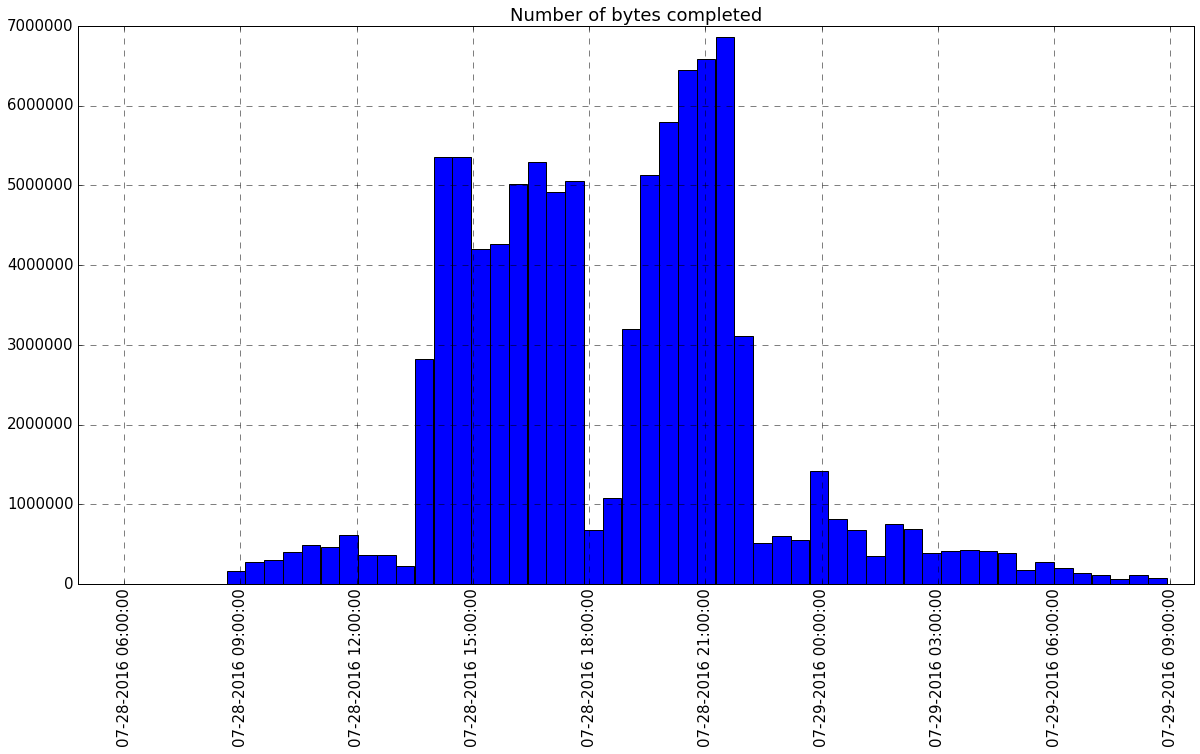

In [12]:
from scipy import stats

bin_means,bin_edges,binnumber = stats.binned_statistic(milliTime,fileSize,'sum',bins=50)

bin_means = bin_means/1e6

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

binTimes = dt.epoch2num(bin_edges/1000.)


plt.figure(figsize=(20,10))
#Throughput measure, recent only
plt.bar(binTimes[:50],bin_means,width=1/50.)
plt.title('Number of bytes completed')
plt.xticks(rotation= 90 )
plt.grid(which='major',linestyle='--')
ax = plt.gca()
#Tedious date/time formatting
xfmt = dt.DateFormatter('%m-%d-%Y %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()

plt.show()

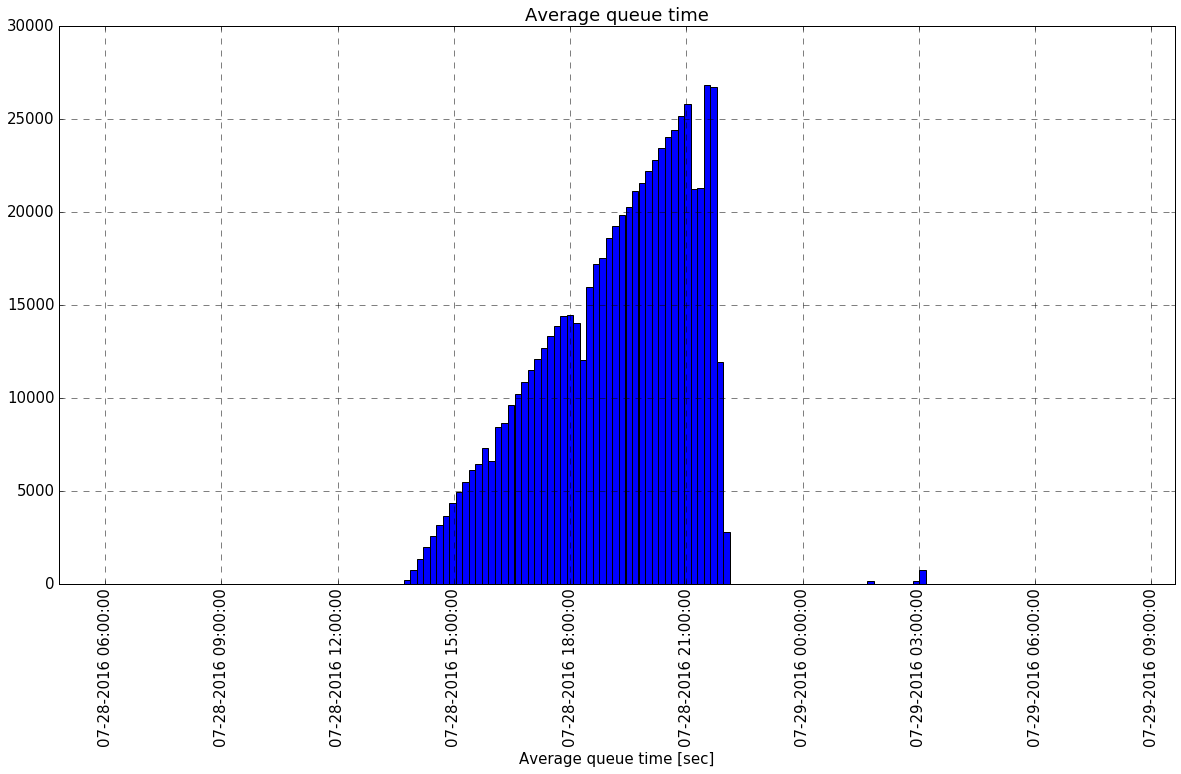

In [13]:
from scipy import stats

binSize = len(queuedData)
bin_means,bin_edges,binnumber = stats.binned_statistic(milliTime,timeInQueue,'mean',bins=binSize)

bin_means = bin_means

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

binTimes = dt.epoch2num(bin_edges/1000.)


plt.figure(figsize=(20,10))
#Throughput measure, recent only
plt.bar(binTimes[:binSize],bin_means,width=1/binSize)
plt.title('Average queue time')
plt.xticks(rotation= 90 )
plt.grid(which='major',linestyle='--')
plt.xlabel('Average queue time [sec]')
ax = plt.gca()
#Tedious date/time formatting
xfmt = dt.DateFormatter('%m-%d-%Y %H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.xaxis_date()

plt.show()

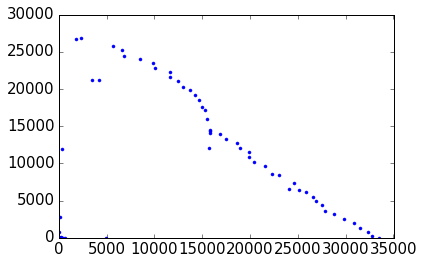

In [18]:
plt.plot(queuedData,bin_means,'b.')

In [19]:
from sklearn import tree, cross_validation,preprocessing
import pandas as pd

#Build dictionary
data = {'activity':activity,'filesize':fileSize}

#Convert to panda dataframe, convert categorical, and convert back
df = pd.DataFrame(data)
dummyActivity = np.array(pd.get_dummies(df['activity']))
treeData = np.hstack((dummyActivity,fileSize[:,None]))


#Create decision tree regressor and fit to data, holding some data
#back for validation

clf = tree.DecisionTreeRegressor(min_samples_split=20,random_state = 90)
clf = clf.fit(treeData,np.array(timeInQueue,dtype=np.int64))

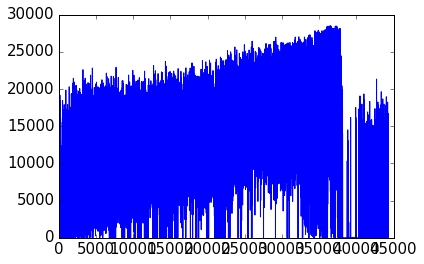

In [21]:
plt.plot(clf.predict(treeData))

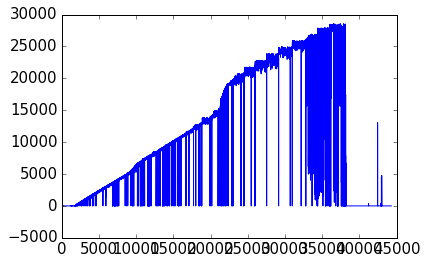

In [22]:
plt.plot(timeInQueue)